# Drug-target interaction prediction using direct & inderect correlation features

In [1]:
import pandas as pd
import numpy as np
import scipy
import itertools
from support_functions import log_progress
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

In [67]:
# load the data
X_std_df = pd.DataFrame.from_csv('features/X_std.csv')
y_df = pd.DataFrame.from_csv('features/y.csv')
metadata_df = pd.DataFrame.from_csv('features/metadata.csv')

In [68]:
# format for sklearn
X_std = X_std_df.values
y = y_df.label.values

___
## Logistic regression

In [58]:
from sklearn.linear_model import LogisticRegression
LogisticRegression?

In [59]:
lr = LogisticRegression(C=100.0, random_state=1, class_weight="balanced", 
                        tol=1e-7, solver='newton-cg', max_iter=1000)
lr.fit(X_std, y)

LogisticRegression(C=100.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=1,
          solver='newton-cg', tol=1e-07, verbose=0, warm_start=False)

In [60]:
metadata_df['prediction'] = lr.predict(X_std)

false_interactions = metadata_df[metadata_df.label==-1]
false_accuracy = (false_interactions[false_interactions.prediction==-1].shape[0] /
                  false_interactions.shape[0])

true_interactions = metadata_df[metadata_df.label==1]
true_accuracy = (true_interactions[true_interactions.prediction==1].shape[0] /
                  true_interactions.shape[0])


print('Accuracy on False interactions: {:.2f}'.format(false_accuracy))
print('Accuracy on True interactions: {:.2f}'.format(true_accuracy))

Accuracy on False interactions: 0.69
Accuracy on True interactions: 0.70


In [61]:
# evaluate top-100 accuracy
metadata_df['prob'] = lr.predict_proba(X_std)[:,1]

In [62]:
unique_cpds = metadata_df.cpd.unique()
top_100_results = pd.DataFrame(index=unique_cpds, columns=['num_targets', 'num_targets_predicted', 'top_target_rank'])

for c in unique_cpds:
    cpd_pairs = metadata_df.query('cpd == "{}"'.format(c)).copy()
    sorted_cpd_pairs = cpd_pairs.sort_values(by=['prob'], ascending=False).reset_index(drop=True)
    
    true_interactions = sorted_cpd_pairs.query('label == 1')
    num_true_interactions = len(true_interactions)
    best_rank = true_interactions.prob.idxmax()
    
    predicted_interactions = sorted_cpd_pairs.query('prediction == 1')
    num_predicted_interactions = len(predicted_interactions)
    
    top_100_results.at[c, 'top_target_rank'] = best_rank
    top_100_results.at[c, 'num_targets'] = num_true_interactions
    top_100_results.at[c, 'num_targets_predicted'] = num_predicted_interactions

In [63]:
top_100_results.head()

,num_targets,num_targets_predicted,top_target_rank
BRD-K21680192,1,1700,804
BRD-K81418486,5,1205,18
BRD-K94441233,1,1307,1484
BRD-K09638361,1,1463,1409
BRD-K08547377,1,321,1463


In [64]:
num_top_100 = len(top_100_results.query('top_target_rank < 101'))
percent_top_100 = num_top_100 / len(top_100_results)
print('Cpds with known target in top 100 predictions: {} ({:.2f})'.format(num_top_100, percent_top_100))

Cpds with known target in top 100 predictions: 30 (0.42)


So here, our very basic logistic regression achieves top-100 accuracy of 42% for 71 compounds using data from 4 different cell lines. In comparison, LR in our LINCS manuscipt achieves top-100 accuracy of 38% for 29 compounds using data from 7 different cell lines.

___
# Random forest classification

In [97]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [98]:
RF = RandomForestClassifier(max_depth=16, random_state=0, n_estimators=100)
RF.fit(X_std, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=16, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [99]:
metadata_df = pd.DataFrame.from_csv('features/metadata.csv')
metadata_df['prediction'] = RF.predict(X_std)

false_interactions = metadata_df[metadata_df.label==-1]
false_accuracy = (false_interactions[false_interactions.prediction==-1].shape[0] /
                  false_interactions.shape[0])

true_interactions = metadata_df[metadata_df.label==1]
true_accuracy = (true_interactions[true_interactions.prediction==1].shape[0] /
                  true_interactions.shape[0])


print('Accuracy on False interactions: {:.6f}'.format(false_accuracy))
print('Accuracy on True interactions: {:.6f}'.format(true_accuracy))

Accuracy on False interactions: 1.000000
Accuracy on True interactions: 0.354430


In [106]:
# evaluate top-100 accuracy
metadata_df['prob'] = RF.predict_proba(X_std)[:,1]
metadata_df[metadata_df.label == 1].head()

,cpd,kd,label,prediction,prob
659,BRD-K85606544,EGFR,1,1,0.587271
667,BRD-K87909389,EGFR,1,-1,0.229551
672,BRD-K66175015,EGFR,1,-1,0.403367
680,BRD-K64052750,EGFR,1,-1,0.494442
2233,BRD-K49328571,CSK,1,1,0.525889


In [114]:
unique_cpds = metadata_df.cpd.unique()
top_100_results = pd.DataFrame(index=unique_cpds, columns=['num_targets', 'num_targets_predicted', 
                                                           'top_target_rank', 'top_prob'])

for c in unique_cpds:
    cpd_pairs = metadata_df.query('cpd == "{}"'.format(c)).copy()
    sorted_cpd_pairs = cpd_pairs.sort_values(by=['prob'], ascending=False).reset_index(drop=True)
    
    true_interactions = sorted_cpd_pairs.query('label == 1')
    num_true_interactions = len(true_interactions)
    best_rank = true_interactions.prob.idxmax()
    top_prob = true_interactions.iloc[0].prob
    
    predicted_interactions = sorted_cpd_pairs.query('prediction == 1')
    num_predicted_interactions = len(predicted_interactions)
    
    top_100_results.at[c, 'top_target_rank'] = best_rank
    top_100_results.at[c, 'num_targets'] = num_true_interactions
    top_100_results.at[c, 'num_targets_predicted'] = num_predicted_interactions
    top_100_results.at[c, 'top_prob'] = top_prob

In [115]:
top_100_results

,num_targets,num_targets_predicted,top_target_rank,top_prob
BRD-K21680192,1,1,0,0.69
BRD-K81418486,5,1,0,0.642999
BRD-K94441233,1,1,0,0.50388
BRD-K09638361,1,0,0,0.203892
BRD-K08547377,1,0,0,0.431249
BRD-K92093830,2,0,0,0.452596
BRD-K92428153,1,0,0,0.324784
BRD-K54233340,2,0,0,0.423326
BRD-K78126613,4,4,0,0.606244
BRD-A45889380,1,0,0,0.325162


In [116]:
num_top_100 = len(top_100_results.query('top_target_rank < 101'))
percent_top_100 = num_top_100 / len(top_100_results)
print('Cpds with known target in top 100 predictions: {} ({:.2f})'.format(num_top_100, percent_top_100))

Cpds with known target in top 100 predictions: 71 (1.00)


Feature ranking:
1. feature 3 (0.086024)
2. feature 13 (0.079479)
3. feature 15 (0.078730)
4. feature 2 (0.076116)
5. feature 12 (0.071254)
6. feature 0 (0.070790)
7. feature 14 (0.068748)
8. feature 1 (0.064570)
9. feature 6 (0.055237)
10. feature 5 (0.053796)
11. feature 9 (0.052843)
12. feature 11 (0.052771)
13. feature 8 (0.049000)
14. feature 7 (0.048934)
15. feature 10 (0.048768)
16. feature 4 (0.042943)


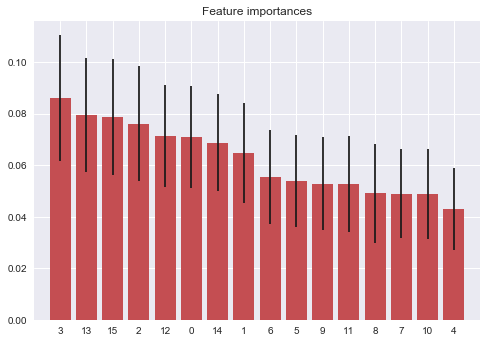

In [117]:
importances = RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0) # standard deviation of importances
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_std.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_std.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_std.shape[1]), indices)
plt.xlim([-1, X_std.shape[1]])
plt.show()

### Validation

In [51]:
# 10-fold cross_validation
RF = RandomForestClassifier(random_state=0, n_estimators=100)
scores = cross_val_score(RF, X_std, y, cv=10)

In [52]:
scores

array([ 0.99865869,  0.99865869,  0.99865869,  0.99871451,  0.99860273,
        0.99865862,  0.99865862,  0.99871444,  0.99882623,  0.99888212])

In [66]:
two_fold_scores = cross_val_score(RF, X_std, y, cv=2)
two_fold_scores

array([ 0.99866981,  0.99868096])

NotFittedError: Estimator not fitted, call `fit` before exploiting the model.